# Boosting

In this lesson, we introduce **Boosting**, a powerful ensemble learning technique that builds models **sequentially** to improve predictive performance.

Just like in Bagging, Boosting is based on combining multiple models — but the way it does this is fundamentally different.

- In **Bagging**, all individual models are built **independently** on random subsets of the data.
- In **Boosting**, models are built **sequentially**, where each new model is trained to **correct the errors** made by the previous ones.

This results in a **model that increasingly focuses on the hard-to-predict examples**, improving accuracy over time.

By the end of this lesson, you should be able to:

- Understand how Boosting works and how it differs from Bagging.
- Explain the idea behind **Adaptive Boosting (AdaBoost)**.
- Understand how Boosting can be combined with **gradient descent**, leading to **Gradient Boosting** methods.

## 1. From Trees to Boosting

Boosting usually employes very simple base models, with a slight better performance over random guessing, which is why they are usually referred to as **weak learners**. And example of this would a decision tree with only one splitting.

The original boosting procedure can be summarized as follows:

1. Draw a random subset (sample) of training examples, $d_1$ , without replacement from the training dataset, to fit a weak learner, $C_1$.
2. Draw a second random training subset, $d_2$, without replacement from the training dataset and add 50 percent of the examples that were misclassified in step 1 to fit another weak learner, $C_2$. 
3. Find the training examples, $d_3$, in the training dataset, which $C_1$ and $C_2$ disagree upon, to fit a third weak learner, $C_3$.
4. Combine the weak learners $C_1$ ,$C_2$, and $C_3$ via majority voting (classification) or averaging (regression).

Boosting can lead to a decrease in bias as well as variance compared to bagging models. As a result, it is not surprising to see algoritmgs unders this procedure scoring at the top in many benchmarking.

## 2. Adaptive Boosting (AdaBoost)

In contrast to the original boosting procedure described before, Adaptive boosting (AdaBoost) uses the complete training data to fit the weak learners, such that in each iteration the training examples are reweighted to build a strong model that learns from the mistakes of the previous weak learners in the ensemble.

The final predictions are then made taking into account all the different iterations.

The original AdaBoost algorithm (Freund & Schapire, 1997) is as follow:

Given:

- A training dataset $X_{ij}$ with labels $y_i \in \{-1, +1\}$ 
- A base learning algorithm  
- A number of boosts $M$


1. Initialize sample weights uniformly:

$$w_i = \frac{1}{n}, \quad \text{for } i = 1, \ldots, n$$

2. for $m = 1 \ldots, M$

    1. Fit a weak learner: $C_m = \mbox{train}(X,y, w)$
    2. Predict class labels: $\hat{y} = \mbox{predict}(C_m, X)$
    3. Compute weighted error rate:
        $$\varepsilon_m = \sum_{i=1}^n w_m \cdot \mathbf{1}(\hat{y}\neq y)$$
   4. Compute the coeffiecient:
        $$\alpha_m = \frac{1}{2} \log\left(\frac{1 - \varepsilon_m}{\varepsilon_m}\right)$$
   5. Update weights:
        $$w_{m+1} = w_m \cdot \exp\left(-\alpha_m \times y_i \times \hat{y}_i\right)$$
   6. Normalize the weights:
        $$w \leftarrow \frac{w}{\sum_{j=1}^n w_j}$$



4. The final prediction is a weighted majority vote:

$$\hat{y} = \left(\sum_{m=1}^M (\alpha_m \times \mbox{predict}(C_m, X))>0\right)$$



Let's see in closer detail

In [1]:
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib.pyplot as plt

X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=42, class_sep=0.15, flip_y=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

0.585
0.61


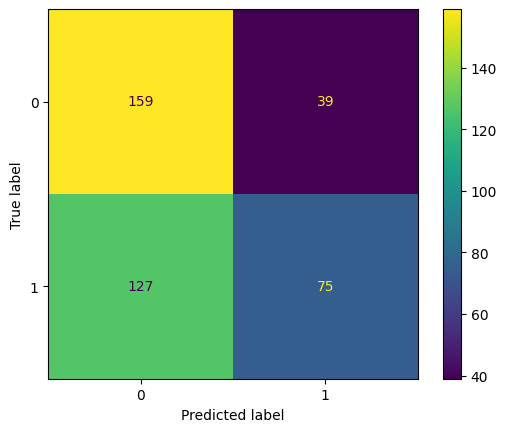

In [2]:
from sklearn.tree import DecisionTreeClassifier


tree = DecisionTreeClassifier(max_depth=1, random_state=1234)
tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, tree.predict(X_train))
ConfusionMatrixDisplay(cm).plot()

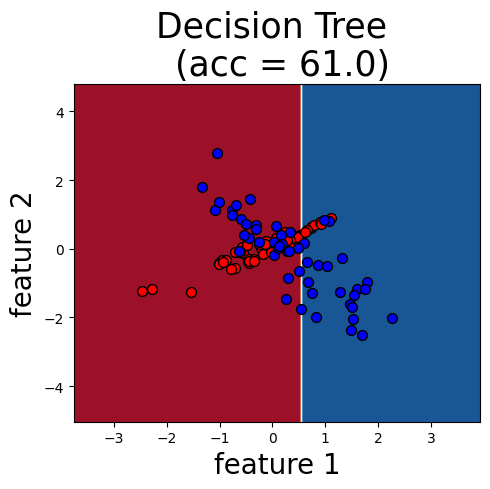

In [3]:
fig, ax = plt.subplots(figsize=(5,5))


DecisionBoundaryDisplay.from_estimator(tree, 
                                       X_train, 
                                       cmap=plt.cm.RdBu, 
                                       response_method="predict", 
                                       ax=ax)

ax.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c="r", edgecolor="black", s=50)
ax.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c="b", edgecolor="black", s=50)
ax.set_title(f"Decision Tree \n (acc = {tree.score(X_test, y_test)*100:.1f})", size=25)
ax.set_xlabel("feature 1", size=20)
ax.set_ylabel("feature 2", size=20)
plt.tight_layout()

Obviously, since the decision tree only has one level, the decision boundary just split the space based on one feature, in this case, feature 1.

As a result and as expected, This classifier sucks. Let's apply AdaBoost recipe to try to improve it.

First, initialize sample weights uniformly:

In [4]:
weights = np.array([1/len(y_train)]*len(y_train))
weights[:10]

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025])

Now, let's suppose we just do 1 boost

In [5]:
# 2. A Fit weak learner
tree.fit(X_train, y_train, sample_weight=weights)

# 2. B Predict class labels 
y_pred_train = tree.predict(X_train)

# 2. C Compute weighted error rate
epsilon = weights.dot(y_pred_train!= y_train) 

# 2. D Compute weighted error rate
alpha = 0.5 * np.log((1 - epsilon) / (epsilon + 1e-10))

# 2. E Update weights
new_weights = weights* np.exp(alpha * (y_pred_train!= y_train) * 2 - alpha)

# 2. F Normalize weights
new_weights /= new_weights.sum()

Let's look at how weights change after this boost.

In [6]:
print("Well-classified example: before boost, w =", 
      weights[y_pred_train==y_train][0], 
      "after boost, w =", 
      new_weights[y_pred_train==y_train][0])

print("Missclassified example: before boost, w =", 
      weights[y_pred_train!=y_train][0], 
      "after boost, w =", 
      new_weights[y_pred_train!=y_train][0])


Well-classified example: before boost, w = 0.0025 after boost, w = 0.002136752137009577
Missclassified example: before boost, w = 0.0025 after boost, w = 0.0030120481924081864


As you can see, those misclassified get a larger weight. And that's good, because that means the next classifier will try to focus more on these particular examples to try to classify them well.

Let's now iterate for 20 boosts, for example:

In [7]:
n_boost = 100
weights = np.ones(len(y_train)) / len(y_train)

learners = []
alphas = []

for ii in range(n_boost):
    clf = DecisionTreeClassifier(max_depth=1, random_state=1234)
    clf.fit(X_train, y_train, sample_weight=weights)

        # 2. A Fit weak learner
    clf.fit(X_train, y_train, sample_weight=weights)
    
    # 2. B Predict class labels 
    y_pred_train = clf.predict(X_train)
    
    # 2. C Compute weighted error rate
    epsilon = weights.dot(y_pred_train!= y_train) 
    
    # 2. D Compute weighted error rate
    alpha = 0.5 * np.log((1 - epsilon) / (epsilon + 1e-10))
    
    # 2. E Update weights
    weights = weights* np.exp(alpha * (y_pred_train!= y_train) * 2 - alpha)
    
    # 2. F Normalize weights
    weights /= weights.sum()

    learners.append(clf)
    alphas.append(alpha)



In [8]:
final_train = 0
final_test = 0
for clf, alpha in zip(learners, alphas):
    y_pred_train = 2*clf.predict(X_train) -1 # as {-1, +1}
    y_pred_test = 2*clf.predict(X_test) - 1 # as {-1, +1}

    final_train += alpha*y_pred_train
    final_test += alpha*y_pred_test

final_train = (final_train >0).astype(int)
final_test = (final_test>0).astype(int)

Then, we select the final labels based on majority based:

In [9]:
print(accuracy_score(y_train, final_train))
print(accuracy_score(y_test, final_test))

0.6775
0.64


So far, we have described AdaBoost in its original form, where each weak learner's contribution to the final prediction is weighted by a factor 
𝛼
𝑡
α 
t
​
  determined entirely by its performance. However, modern implementations of AdaBoost typically introduce a learning rate — a hyperparameter that scales these 
𝛼
𝑡
α 
t
​
  values.

The learning rate controls how much each individual learner contributes to the final model. This idea, known as shrinkage, helps improve generalization by preventing overconfident updates and reducing the risk of overfitting. Although it slows down the learning process, it often results in better performance, especially when combined with a larger number of estimators.

### 2.1 Implementation in scikit-learn

`scikit-learn` provides convenient implementations of AdaBoost through the `ensemble.AdaBoostClassifier` and `ensemble.AdaBoostRegressor` classes, which can be used for classification and regression tasks, respectively. 

<div class="alert alert-info"> 

𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓

Modern implementations of AdaBoost typically introduce a **learning rate**, a hyperparameter that scales the learner weights $\alpha$.

The learning rate controls how much each individual learner contributes to the final model. For example, a higher learning rate increases the impact of each classifier. While this can improve performance, it also increases the risk of overfitting — so tuning this parameter is essential.

`scikit-learn` includes this option in both `ensemble.AdaBoostClassifier` and `ensemble.AdaBoostRegressor`.

</div>



Let's reproduce what we had seen before, but now with this implementation

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=1234),
                         n_estimators=100,
                         learning_rate=1,
                         algorithm='SAMME', 
                         random_state=10)

ada.fit(X_train, y_train)

print(ada.score(X_train, y_train), ada.score(X_test, y_test))

0.6775 0.64


Let's see the boundary decision of AdaBoost and compare it with the original and base Decision Tree:

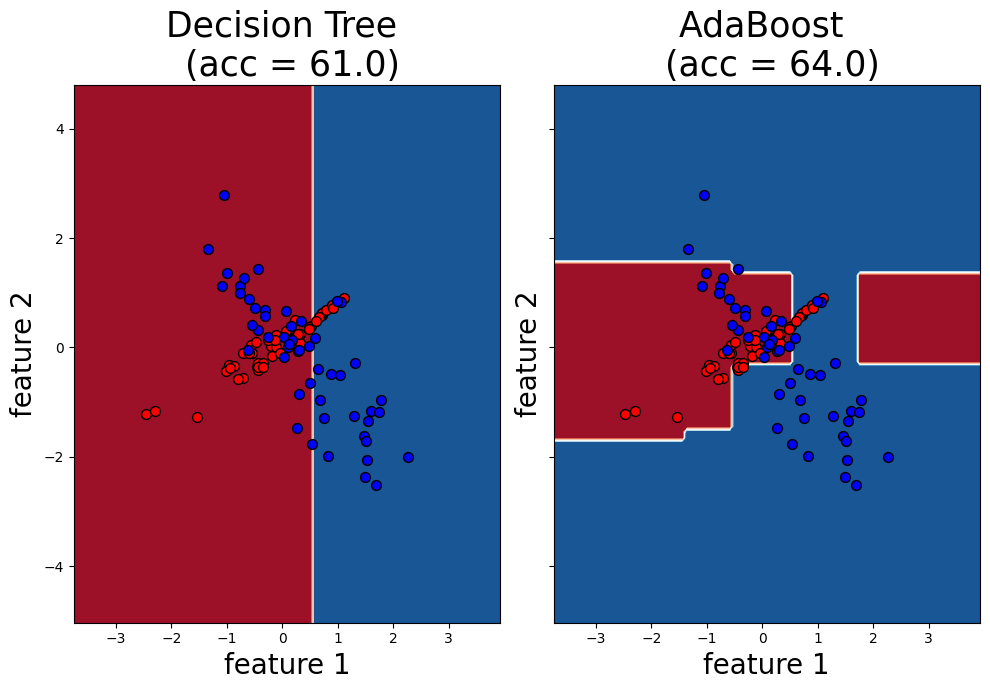

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10,7), sharey=True)

for ii, (case, estim) in enumerate(zip(["Decision Tree","AdaBoost"], 
                                       [tree, ada])):
    DecisionBoundaryDisplay.from_estimator(estim, 
                                           X_train, 
                                           cmap=plt.cm.RdBu, 
                                           response_method="predict", 
                                           ax=axs[ii])

    axs[ii].scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c="r", edgecolor="black", s=50)
    axs[ii].scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c="b", edgecolor="black", s=50)
    axs[ii].set_title(f"{case} \n (acc = {estim.score(X_test, y_test)*100:.1f})", size=25)
    axs[ii].set_xlabel("feature 1", size=20)
    axs[ii].set_ylabel("feature 2", size=20)
plt.tight_layout()

**Although the performance improvement is not the biggest in the world, we can see that AdaBoost introduces additional flexibility to the decision boundaries, resulting in better classification of some observations.**

### 2.2 Pause and think exercise: Boosting with Logistic Regression

Replicate the same using a `LogisticRegression` as a base learner, instead of the decision tree. Compare this to using a `LogisticRegression` alone.

After this, respond to:

- How does the performance of boosted logistic regression compare to a single logistic regression model?
- Why do you think boosting does not work here as effectively?

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train, y_train)
print(logReg.score(X_train, y_train), logReg.score(X_test, y_test))

ada_log = AdaBoostClassifier(estimator=LogisticRegression(),
                             n_estimators=100,
                             learning_rate=1,
                             algorithm='SAMME', 
                             random_state=10)

ada_log.fit(X_train, y_train)

print(ada_log.score(X_train, y_train), 
      ada_log.score(X_test, y_test))

0.5775 0.66
0.555 0.59


## 3. Gradient Boosting: Boosting + Gradient Descent

Gradient Boosting combines ideas from **Boosting** and **Gradient Descent**.

Why? Because instead of reweighting samples like AdaBoost, Gradient Boosting fits each new model to the **residual errors** of the current ensemble, using **gradient descent** on a chosen loss function.

We are not going to get into the math here (refer to Chapter 7 for that), but the key idea is:

- Start with a simple model that makes an initial prediction.
- At each step, compute how the current model is wrong (residuals or gradients of the loss).
- Fit a new weak learner (usually a shallow decision tree) to these residuals.
- Add the predictions of this learner to the existing model, scaled by a **learning rate**.

As a result, the optimization is guided by **loss gradients**, not by weighted classification errors.

This process is repeated for many iterations, gradually improving the model’s performance by reducing the loss.

Gradient Boosting works with **any differentiable loss function** (e.g., squared error for regression, log-loss for classification).

It is more **flexible and powerful** than AdaBoost in practice — but also **more sensitive to overfitting**, especially if trees are too deep or if the learning rate is too high.


### 3.1 Implementation in scikit-learn

`scikit-learn` provides easy-to-use implementations of Gradient Boosting through `ensemle.GradientBoostingRegressor` and `ensemle.GradientBoostingClassifier`.

These models follow the principles described above: they sequentially add shallow trees to correct the errors of the current ensemble, using gradient descent to minimize a specified loss function.


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
# Fit gradient boosting model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=2, random_state=1234)
gb.fit(X_train, y_train)

# Evaluate
#print(f"Train Accuracy: {accuracy_score(y_train, gb.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, gb.predict(X_test)):.2f}")

Test Accuracy: 0.76


And let's compare the decision boundaries:

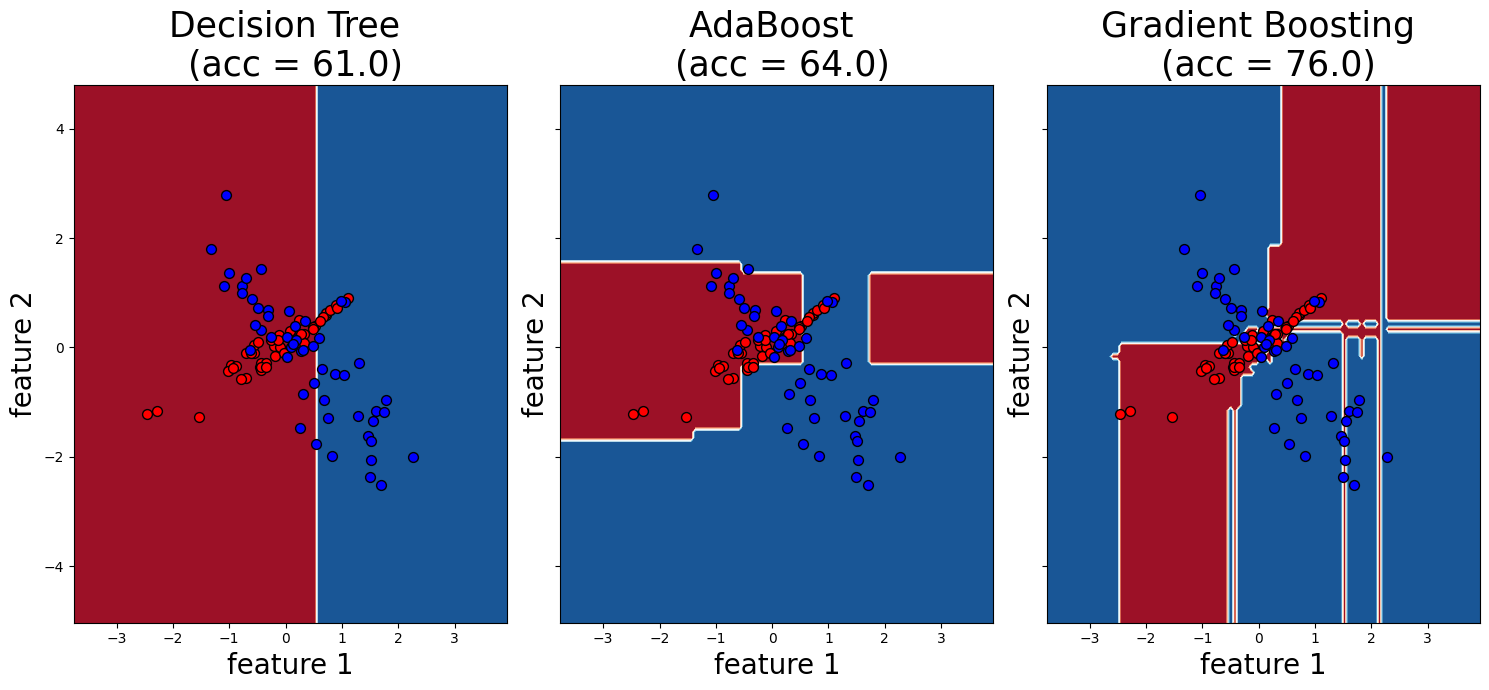

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15,7), sharey=True)

for ii, (case, estim) in enumerate(zip(["Decision Tree","AdaBoost", "Gradient Boosting"], 
                                       [tree, ada, gb])):
    DecisionBoundaryDisplay.from_estimator(estim, 
                                           X_train, 
                                           cmap=plt.cm.RdBu, 
                                           response_method="predict", 
                                           ax=axs[ii])

    axs[ii].scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c="r", edgecolor="black", s=50)
    axs[ii].scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c="b", edgecolor="black", s=50)
    axs[ii].set_title(f"{case} \n (acc = {estim.score(X_test, y_test)*100:.1f})", size=25)
    axs[ii].set_xlabel("feature 1", size=20)
    axs[ii].set_ylabel("feature 2", size=20)

plt.tight_layout()

## 4. Explainability

In Boosting, the same principles as in Bagging apply in terms of explainability.

If the base learners are inherently explainable models—such as Decision Trees or Linear/Logistic Regression—then one can estimate feature importance by averaging individual importance scores (e.g., beta coefficients in regression models) across the ensemble.

Similar to Random Forests in `scikit-learn`, both AdaBoost and Gradient Boosting models provide a `feature_importances_` attribute when the base learner is a decision tree. This attribute automatically **averages the importance scores across all trees**, yielding a single importance value for each feature.

Although not implemented by default in `scikit-learn`, a similar approach could, in principle, be applied when using other base learners, such as Linear or Logistic Regression.

In [15]:
ada.feature_importances_

array([0.20689314, 0.79310686])

In [16]:
gb.feature_importances_

array([0.31677659, 0.68322341])

## 5. Summary

- **Boosting** is an ensemble technique that combines weak learners in a **sequential** manner, where each new model focuses on the **errors** made by the previous ones.
- In **Adaptive Boosting (AdaBoost)**,  models are trained with **weighted** data to to emphasize previously misclassified examples.
- **Gradient Boosting**, instead, generalizes this idea by using gradient descent to iteratively minimize a chosen loss function.

## 📝 6. Exercises

### 6.1 Exercise  – AdaBoost for Regression

In this exercise you will be using `AdaBoostRegressor` to solve a simple regression problem, and manually verify that the final prediction is a **weighted average** of the weak learners' predictions.

In order, do the following:

1. Generate a toy dataset. You can use the function `make_regression` from `scikit-learn` for this.

2. Split it into training and testing sets.

3. Use `AdaBoostRegressor` to fit the training set. Use a decision tree with just one level as the base model, and at least 20 boosts.

4. Create a scatter plot showing the predictions vs observed values in the test set. Add also how well the model performs in the title of the plot.

5. Replicate the predictions in 4 manually. For this, use each base learner and weight from the `.estimators_` and `.estimator_weights_` attributes after fitting the AdaBoost, and compute the final prediction as the **weighted average** of the individual predictions.

In [17]:
#YOUR CODE

### 6.2 Exercise – Gradient Boosting with Learning Rate Tuning

In this exercise, you will explore how the learning rate affects Gradient Boosting performance.

Using the same toy data as the one used throughout this tutorial:

1. Calculate the training accuracy and test accuracy for a varying range of learning rates.  You may try this list of values: 0.001, 0.01, 0.1, 0.3, 0.5, and 1.0.

2. Plot these accuracies against the learning rates.  

3. Plot the decision boundaries for a couple of extreme cases (e.g., very low and very high learning rates).  You may the same visualization function we have used above.

**Discussion**: How do performances behave with the learning rate? Are training and test accuracies aligned? What happens to the decision boundary as the learning rate increases?

In [18]:
#YOUR CODE